# Keyword (n-grams) extraction with TF-IDF and SKlearn (based on title and description fields)

# Defining constants and variables

In [283]:
import fnmatch
import os

In [284]:


myFileName = ''
for file in os.listdir('./data'):
    if fnmatch.fnmatch(file, 'incid*'):
        print(file)
        myFileName = file

incidents.xlsx


In [285]:
myFileName

'incidents.xlsx'

In [286]:
# filename = r'\\drive\data_hub\raw_data'+'\\'+myFileName
filename = r'data/'+myFileName+''
column_names = ['incident_id', 'status', 'name', 'period', 'description']

# Dataset | Loading

In [287]:
import pandas as pd
df_idf = pd.read_excel(r''+filename+'', index_col=None, na_values=['NA'])

In [288]:
print("Schema:\n\n", df_idf.dtypes)
print("Number of questions, columns=", df_idf.shape)

Schema:

 incident_id     int64
status         object
name           object
period         object
description    object
dtype: object
Number of questions, columns= (10, 5)


In [289]:
df_idf.head()

,incident_id,status,name,period,description
0,1,Open,Hidden Financial Risks That Regulators Miss,2021-02,Behavioral economists have shown that people a...
1,2,Closed,"Environmental, social and governance issues",2021-01,brings to mind environmental issues like clima...
2,3,Draft,Cybersecurity,2021-01,unwanted or unexpected cyber security event
3,4,Cancelled,Credit,2021-03,possibility of a loss resulting from a borrowe...
4,5,Draft,Regulatory/compliance,2021-03,"organization's adherence to laws, regulations,..."


# Data Preparation

## Selecting one reporting period (optional)

In [290]:
#df_idf = df_idf[df_idf['period']=='2021-02']

## Triming away unnecessary fields/columns

In [291]:
df_idf = df_idf[column_names]
df_idf.count()

incident_id    10
status         10
name           10
period         10
description    10
dtype: int64

## Filtering out Incidents that contain "nan"

In [292]:
#df_idf = df.idf.loc[(df_idf['name'].astype(str) != 'nan')]

In [293]:
print("Number of questions, columns=", df_idf.shape)

Number of questions, columns= (10, 5)


## Concatenating various fields in a new dedicated column

In [294]:
# Cleansing | getting rid of rows having null values for Incident description field
#df_idf = df_idf[~df_idf['description'].isnull()]

In [295]:
df_idf['text to be mined'] = df_idf['name'].fillna("") + ' ' + df_idf['description'].fillna("")

In [296]:
print("Number of questions, columns=", df_idf.shape)

Number of questions, columns= (10, 6)


## Pre-processing method (lower case, removing tags, etc.)

In [297]:
import re

In [298]:
def pre_process(text):
    text = text.lower()
    
    text = re.sub(r'[\.]', '', text)
    
    # Replace any character presents with a space except letters from a to z
    text = re.sub(r'[^a-z]', ' ', text)
    # text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # Remove tags
    # text = re.sub(r"&lt;/?.*?&gt;", " &lt;&gt; ", text)
    
    # Remove special characters and digits
    # text = re.sub(r"(\\d|\\W)+", " ", text)
    
    # Remove non-desired sentences
    text = re.sub('TOPIC1', '', text)
    text = re.sub('TOPIC2', '', text)
    text = re.sub('TOPIC3', '', text)
    
    # Remove double spaces or more
    text = re.sub(' +', ' ', text)
    
    # Correcting typos in the text (a dedicated dictionary could be created)
    text = re.sub('invetment', 'investment', text)
    text = re.sub('incorrcet', 'incorrect', text)
    text = re.sub('encrpytion', 'encryption', text)
    
    
    # Adapting abbreviations
    text = re.sub('swiss airlines', 'swissair', text)
    text = re.sub('guzman and gomez', 'guzman y gomez', text)
    text = re.sub('guzman & gomez', 'guzman y gomez', text)
    text = re.sub('guzman/gomez', 'guzman y gomez', text)
    
    return text
    

## Calling pre-processing method

A lambda function is a small anonymous function | it can take any number of arguments, but can only have one expression:
e.g. x = lambda a, b: a * b
print(x(5, 6))

In [299]:
df_idf['text to be mined'] = df_idf['text to be mined'].apply(lambda x:pre_process(x))

In [300]:
print("Number of questions, columns=", df_idf.shape)

Number of questions, columns= (10, 6)


## Retrieving the length and number of words

In [301]:
df_idf['length'] = df_idf['text to be mined'].astype(str).apply(len)
df_idf['word_count'] = df_idf['text to be mined'].apply(lambda x: len(str(x).split()))

## Creating a list of words | Convert to string (using .str or astype(str)) + split()

In [302]:
df_idf['raw text'] = df_idf['text to be mined'].str.split()

df_idf['raw text'][:10]

0    [hidden, financial, risks, that, regulators, m...
1    [environmental, social, and, governance, issue...
2    [cybersecurity, unwanted, or, unexpected, cybe...
3    [credit, possibility, of, a, loss, resulting, ...
4    [regulatory, compliance, organization, s, adhe...
5    [strategic, arise, from, the, fundamental, dec...
6    [operational, resilience, entity, s, ability, ...
7    [conduct, and, culture, inappropriate, unethic...
8    [reputation, poor, coordination, of, the, deci...
9    [perceived, reputational, risk, oil, drillers,...
Name: raw text, dtype: object

## Capitalising entity names

Necessary so that, for instance, 'cbas' doesn't get transformed into 'cba' when lemmatized.

'CBAS' --> lemmatized --> 'CBAS'
'cbas' --> lemmatized --> 'cba'

In [303]:
def capitalising_entity_names(text):
    if(text.strip()=='swiss'):
        text = 'SWISS'
        
    if(text.strip()=='nsw'):
        text = 'NSW'     
        
    if(text.strip()=='vs'):
        text = 'VS'          
        
    return text

In [304]:
df_idf['raw text'] = df_idf['raw text'].apply(lambda x: [capitalising_entity_names(y) for y in x])

In [305]:
df_idf['raw text'][:10]

0    [hidden, financial, risks, that, regulators, m...
1    [environmental, social, and, governance, issue...
2    [cybersecurity, unwanted, or, unexpected, cybe...
3    [credit, possibility, of, a, loss, resulting, ...
4    [regulatory, compliance, organization, s, adhe...
5    [strategic, arise, from, the, fundamental, dec...
6    [operational, resilience, entity, s, ability, ...
7    [conduct, and, culture, inappropriate, unethic...
8    [reputation, poor, coordination, of, the, deci...
9    [perceived, reputational, risk, oil, drillers,...
Name: raw text, dtype: object

# Stemming or Lemmatization

In [306]:
from nltk.stem import PorterStemmer

# Mor aggressive algorithm. You can add your own custom rules!
from nltk.stem import LancasterStemmer

from nltk.tokenize import word_tokenize
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

ps = PorterStemmer()
ls = LancasterStemmer()

lemmatizer = WordNetLemmatizer()

## Lemmatization

In [307]:
# Lemmatization | produce an actual language word | lemmatize produces more keywords in this case
# the for allows us to loop each and every word in each cell
df_idf['stemmed_or_lemmatized_text'] = df_idf['raw text'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
df_idf['stemmed_or_lemmatized_text'].head()

0    [hidden, financial, risk, that, regulator, mis...
1    [environmental, social, and, governance, issue...
2    [cybersecurity, unwanted, or, unexpected, cybe...
3    [credit, possibility, of, a, loss, resulting, ...
4    [regulatory, compliance, organization, s, adhe...
Name: stemmed_or_lemmatized_text, dtype: object

## Stemming

In [308]:
# Stemming | might not produce an actual language word
# df_idf['stemmed_or_lemmatized_text'] = df_idf['raw text'].apply(lambda x: [ps.stem(y) for y in x])
# df_idf['stemmed_or_lemmatized_text'].head()

## Convert list back to string and get rid of []

In [309]:
df_idf['stemmed_or_lemmatized_text'] = df_idf['stemmed_or_lemmatized_text'].apply(lambda x: ' '.join(map(str, x)).strip('[]'))
df_idf['text to be mined'] = df_idf['stemmed_or_lemmatized_text']
df_idf['text to be mined'].head()

0    hidden financial risk that regulator miss beha...
1    environmental social and governance issue brin...
2    cybersecurity unwanted or unexpected cyber sec...
3    credit possibility of a loss resulting from a ...
4    regulatory compliance organization s adherence...
Name: text to be mined, dtype: object

# example | tokenization

In [310]:
sentence = "Chaos Scientist Finds Hidden Financial Risks That Regulators Miss. Oxford Professor Doyne Farmer is working with central banks to improve stress testing."

# Tokenization | creating a list of words
words_tokenized = word_tokenize(sentence)

for w in words_tokenized:
    print(w, "|\t", ps.stem(w), "|\t", ls.stem(w), "|\t", lemmatizer.lemmatize(w))

Chaos |	 chao |	 chao |	 Chaos
Scientist |	 scientist |	 sci |	 Scientist
Finds |	 find |	 find |	 Finds
Hidden |	 hidden |	 hid |	 Hidden
Financial |	 financi |	 fin |	 Financial
Risks |	 risk |	 risk |	 Risks
That |	 that |	 that |	 That
Regulators |	 regul |	 reg |	 Regulators
Miss |	 miss |	 miss |	 Miss
. |	 . |	 . |	 .
Oxford |	 oxford |	 oxford |	 Oxford
Professor |	 professor |	 profess |	 Professor
Doyne |	 doyn |	 doyn |	 Doyne
Farmer |	 farmer |	 farm |	 Farmer
is |	 is |	 is |	 is
working |	 work |	 work |	 working
with |	 with |	 with |	 with
central |	 central |	 cent |	 central
banks |	 bank |	 bank |	 bank
to |	 to |	 to |	 to
improve |	 improv |	 improv |	 improve
stress |	 stress |	 stress |	 stress
testing |	 test |	 test |	 testing
. |	 . |	 . |	 .


# Creating the IDF

## STOPWORDS | define and enrich a list of stopwords

In [311]:
from nltk.corpus import stopwords

In [312]:
# Loading a set of stopwords
# stopwords = get_stop_words('resources/stopwords.txt')

# def get_stop_words(stop_file_path):
#    ''' Load stop words '''
#    with open(stop_file_path, 'r', encoding='utf-8') as f:
#        stopwords = f.readlines()
#        stop_set = set(m.strip() for m in stopwords)
#        return frozenset(stop_set)

In [313]:
# Creating a list of stopwords
stop_words = set(stopwords.words('English'))
stop_words

# Adding custom stopwords to a list of stopwords
new_words = ['t', 'nan', 'th', 'a']

stop_words_customized = stop_words.union(new_words)

## CountVectorizer to create a vocabulary and generate word counts

The next step is to start the counting process. We can use the CountVectorizer to create a vocabulary from all the text in our df_idf['text to be mined'] and generate counts for each row in df['text to be mined']. The result of the last two lines is a sparse matrix representation of the counts, meaning each column represents a word in the vocabulary and each row represents the document in our dataset where the values are the word counts. Note that with this representation, counts of some words could be 0 if the word did not appear in the corresponding document.

In [314]:
from sklearn.feature_extraction.text import CountVectorizer

# Get the txt column
docs = df_idf['text to be mined'].tolist()
docs

['hidden financial risk that regulator miss behavioral economist have shown that people aren t perfect calculator and often make rule of thumb judgment such a concluding that rising market will keep going up despite other evidence to the contrary',
 'environmental social and governance issue brings to mind environmental issue like climate change and resource scarcity',
 'cybersecurity unwanted or unexpected cyber security event',
 'credit possibility of a loss resulting from a borrower s failure to repay a loan or meet contractual obligation',
 'regulatory compliance organization s adherence to law regulation guideline and specification relevant to it business process',
 'strategic arise from the fundamental decision that director take concerning an organisation s objective',
 'operational resilience entity s ability to withstand and recover from shock',
 'conduct and culture inappropriate unethical or unlawful behaviour on the part of an organisation s management or employee',
 'reput

## Create a vocabulary of words | ALL COMBINATIONS

In [315]:
# Ignore words that appear in 90% (was 85%) of documents
# range (2, 5), i.e. bigrams, trigrams, fourgrams and fivegrams
# Eliminate stop words

cv = CountVectorizer(max_df=0.85, ngram_range=(2, 5), stop_words = stop_words_customized)

word_count_vector = cv.fit_transform(docs)

# Shape of the resulting vector
word_count_vector.shape

(10, 328)

In [316]:
# Extract feature names
feature_names = cv.get_feature_names()

### Exporting the vocabulary of words | ALL COMBINATIONS

In [317]:
df_vocabulary_of_words = pd.DataFrame(list(feature_names), columns=['Keywords (ALL COMBINATIONS)'])
df_vocabulary_of_words.to_excel(r'outputs/vocabulary_of_words_all_combinations.xlsx')

## Create a vocabulary of words | LIMITED COMBINATIONS

In some of the text mining applications, such as clustering and text classification we limit the size of the vocabulary. It's really easy to do this by setting max_features=vocab_size when instantiating CountVectorizer

Let's limit it to 300.

In [318]:
# cv_limited = CountVectorizer(max_df=0.85, ngram_range=(2,5), stop_words=stop_words_customized, max_features=300)

# word_count_vector_limited = cv_limited.fit_transform(docs)

# Shape of the resulting vector
#word_count_vector_limited.shape

In [319]:
# Extract feature names
# feature_names_limited = cv_limited.get_feature_names()

### Exporting the vocabulary of words | LIMITED COMBINATIONS

In [320]:
# df_vocabulary_of_words_limited = pd.DataFrame(list(feature_names_limited), columns=['Keywords (LIMITED COMBINATIONS)'])
# df_vocabulary_of_words_limited.to_excel(r'outputs/vocabulary_of_words_limited_combinations.xlsx')

# TfidfTransformer to Compute Inverse Document Frequency (IDF)

In the code below, we are essentially taking the sparse matrix from CountVectorizer to generate the IDF when you invoke fit.

An extremely important point to note here is that the <b>IDF should be based on a large corpora</b> and should <b>be representative of texts you would be using to extract keywords</b>.

I've seen several articles on the web that compute the IDF using an handful of documents.

To understand why IDF should be based on a fairly large collection, please read this [page from Standford's IR book] (https://nlp.stanford.edu/IR-book/html/htmledition/inverse-document-frequency-1.html).

In [321]:
from sklearn.feature_extraction.text import TfidfTransformer

## TF-IDF | ALL COMBINATIONS

In [322]:
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [323]:
# Let's look at some of the IDF values:
tfidf_transformer.idf_
len(tfidf_transformer.idf_)

328

## TF-IDF | LIMITED COMBINATIONS

In [324]:
# tfidf_transformer_limited = TfidfTransformer(smooth_idf=True, use_idf=True)
# tfidf_transformer_limited.fit(word_count_vector_limited)

In [325]:
# Let's look at some of the IDF values:
# tfidf_transformer_limited.idf_
# len(tfidf_transformer_limited.idf_)

# Computing TF-IDF and extracting keywords for each Incidents

Once we have our IDF computed, we are now ready to compute TF-IDF and extract the top keywords. In this example, we will extract top keywords for all our Incidents stored in our Excel spreadsheet (or csv, json, etc.)

We will start by reading the file, extracting the necessary fields in a dataframe (name + description) and get the texts into a list.

In [326]:
df_tfidf = pd.read_excel(r''+filename+'', index_col=None, na_values=['NA'])
# df_tfidf = pd.read_json("data/incidents.json, lines=True")

df_tfidf = df_tfidf[column_names]

In [327]:
df_tfidf

,incident_id,status,name,period,description
0,1,Open,Hidden Financial Risks That Regulators Miss,2021-02,Behavioral economists have shown that people a...
1,2,Closed,"Environmental, social and governance issues",2021-01,brings to mind environmental issues like clima...
2,3,Draft,Cybersecurity,2021-01,unwanted or unexpected cyber security event
3,4,Cancelled,Credit,2021-03,possibility of a loss resulting from a borrowe...
4,5,Draft,Regulatory/compliance,2021-03,"organization's adherence to laws, regulations,..."
5,6,Open,Strategic,2021-03,arise from the fundamental decisions that dire...
6,7,Open,Operational resilience,2021-03,entity's ability to withstand and recover from...
7,8,Open,Conduct and culture,2020-12,"inappropriate, unethical or unlawful behaviour..."
8,9,Closed,Reputation,2020-10,poor coordination of the decisions made by dif...
9,10,Closed,perceived reputational risk,2020-09,oil drillers and gun manufacturers


In [328]:
df_tfidf.count()

incident_id    10
status         10
name           10
period         10
description    10
dtype: int64

In [329]:
# print schema
print("Schema:\n\n", df_tfidf.dtypes)
print("Number of questions,columns=", df_tfidf.shape)

Schema:

 incident_id     int64
status         object
name           object
period         object
description    object
dtype: object
Number of questions,columns= (10, 5)


# Concatenating | NAME + DESCRIPTION

In [330]:
df_tfidf['text to be mined'] = df_tfidf['name'].fillna("") + ' ' +df_tfidf['description'].fillna("")
df_tfidf['text to be mined']

0    Hidden Financial Risks That Regulators Miss Be...
1    Environmental, social and governance issues br...
2    Cybersecurity unwanted or unexpected cyber sec...
3    Credit possibility of a loss resulting from a ...
4    Regulatory/compliance organization's adherence...
5    Strategic arise from the fundamental decisions...
6    Operational resilience entity's ability to wit...
7    Conduct and culture inappropriate, unethical o...
8    Reputation poor coordination of the decisions ...
9    perceived reputational risk oil drillers and g...
Name: text to be mined, dtype: object

In [331]:
# Cleansing | getting rid of rows having null values for description
# df_tfidf = df_tfidf[~df_tfidf['text to be mined'].isnull()]
# df_tfidf

## Calling pre-processing method

In [332]:
df_tfidf['text to be mined'] = df_tfidf['text to be mined'].astype(str).apply(lambda x: pre_process(x))

## Retrieving the length and number of words

In [333]:
# Two new columns for lengths of the description and word count
df_tfidf['length'] = df_tfidf['text to be mined'].astype(str).apply(len)
df_tfidf['word_count'] = df_tfidf['text to be mined'].apply(lambda x: len(str(x).split()))

In [334]:
df_tfidf

,incident_id,status,name,period,description,text to be mined,length,word_count
0,1,Open,Hidden Financial Risks That Regulators Miss,2021-02,Behavioral economists have shown that people a...,hidden financial risks that regulators miss be...,251,39
1,2,Closed,"Environmental, social and governance issues",2021-01,brings to mind environmental issues like clima...,environmental social and governance issues bri...,120,16
2,3,Draft,Cybersecurity,2021-01,unwanted or unexpected cyber security event,cybersecurity unwanted or unexpected cyber sec...,57,7
3,4,Cancelled,Credit,2021-03,possibility of a loss resulting from a borrowe...,credit possibility of a loss resulting from a ...,112,19
4,5,Draft,Regulatory/compliance,2021-03,"organization's adherence to laws, regulations,...",regulatory compliance organization s adherence...,131,16
5,6,Open,Strategic,2021-03,arise from the fundamental decisions that dire...,strategic arise from the fundamental decisions...,106,14
6,7,Open,Operational resilience,2021-03,entity's ability to withstand and recover from...,operational resilience entity s ability to wit...,76,11
7,8,Open,Conduct and culture,2020-12,"inappropriate, unethical or unlawful behaviour...",conduct and culture inappropriate unethical or...,122,18
8,9,Closed,Reputation,2020-10,poor coordination of the decisions made by dif...,reputation poor coordination of the decisions ...,92,13
9,10,Closed,perceived reputational risk,2020-09,oil drillers and gun manufacturers,perceived reputational risk oil drillers and g...,62,8


## Creating a list of words | Convert to string (using .str or astype(str)) + split()

In [335]:
df_tfidf['raw_text'] = df_tfidf['text to be mined'].str.split()
df_tfidf['raw_text']

0    [hidden, financial, risks, that, regulators, m...
1    [environmental, social, and, governance, issue...
2    [cybersecurity, unwanted, or, unexpected, cybe...
3    [credit, possibility, of, a, loss, resulting, ...
4    [regulatory, compliance, organization, s, adhe...
5    [strategic, arise, from, the, fundamental, dec...
6    [operational, resilience, entity, s, ability, ...
7    [conduct, and, culture, inappropriate, unethic...
8    [reputation, poor, coordination, of, the, deci...
9    [perceived, reputational, risk, oil, drillers,...
Name: raw_text, dtype: object

## Capitalising entity names

In [336]:
df_tfidf['raw_text'] = df_tfidf['raw_text'].apply(lambda x: [capitalising_entity_names(y) for y in x])

## Stemming or Lemmatization

In [337]:
df_tfidf['stemmed_or_lemmatized_text'] = df_tfidf['raw_text'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

## Convert list back to string and get rid of []

In [338]:
df_tfidf['stemmed_or_lemmatized_text'] = df_tfidf['stemmed_or_lemmatized_text'].apply(lambda x: ' '.join(map(str, x)).strip('[]'))
df_tfidf['text to be mined'] = df_tfidf['stemmed_or_lemmatized_text']
df_tfidf['text to be mined'].head()

0    hidden financial risk that regulator miss beha...
1    environmental social and governance issue brin...
2    cybersecurity unwanted or unexpected cyber sec...
3    credit possibility of a loss resulting from a ...
4    regulatory compliance organization s adherence...
Name: text to be mined, dtype: object

# Get test docs into a list

In [339]:
docs_text_to_be_mined = df_tfidf['text to be mined']

# Extracting ngrams | FUNCTIONS

In [340]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

In [341]:
# With weigthing
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """ get the feature names and tf-idf score of top n items"""
    
    # Use only topn items from vector
    sorted_items = sorted_items[:topn]
    
    score_vals = []
    feature_vals = []
    
    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        # keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
        
    # create a tuples of feature,score
    # results = zip(feature_vals, score_vals)
    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
        
    return results

In [342]:
# Without weigthing
def extract_topn_from_vector_keyword_only(feature_names, sorted_items, topn=10):
    """ get the feature names and tf-idf score of top n items"""
    
    # Use only topn items from vector
    sorted_items = sorted_items[:topn]
    
    score_vals = []
    feature_vals = []
    
    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        # keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
        
    # create a tuples of feature,score
    # results = zip(feature_vals, score_vals)
    results = ''
    for idx in range(len(feature_vals)):
        results += feature_vals[idx]
        results += ','
        
    return results

# Generating keywords for a batch of documents (without weighting) | ALL COMBINATIONS

The next step is to compute the tf-idf value for a given document in our test set by invoking tfidf_transformer.transform(...). This generates a vector of tf-idf scores. Next, we sort the words in the vector in descending order of tf-idf values and then iterate over to extract the top-n items with the corresponding feature names, in the example below, we are extracting keywords for the first document in our test set.

The sort_coo() method essentially sorts the values in the vector while preserving the column index. once you have the column index then its really easy to look-up the corresponding word value as you would see in extract_topn_from_vector(...) where we do feature_vals.append(feature_names[idx])

In [343]:
# generate tf-idf for all documents in your list. docs_text_to_be_mined has X documents
tf_idf_vector = tfidf_transformer.transform(cv.transform(docs_text_to_be_mined))

print(tf_idf_vector.shape[0])

results=[]
for i in range(tf_idf_vector.shape[0]):
    
    # get vector for a single document
    curr_vector = tf_idf_vector[i]
    
    # sort the tf-idf vector by descending order of scores
    sorted_items = sort_coo(curr_vector.tocoo())
    
    # extract only the top n; n here is 10 - keywords only, without weighting
    keywords=extract_topn_from_vector_keyword_only(feature_names, sorted_items, 10)
    
    results.append(keywords)
    
df_tfidf['keywords (all combinations) without weighting'] = results

# drop unnecessary columns
df_tfidf.drop(['raw_text', 'stemmed_or_lemmatized_text'], axis = 1)

# df_tfidf.rename(columns={'text': 'text to be mined'})
df_tfidf.to_excel('outputs/incidents by period with keywords (all combinations) without weighting.xlsx')

10


In [344]:
df_tfidf

,incident_id,status,name,period,description,text to be mined,length,word_count,raw_text,stemmed_or_lemmatized_text,keywords (all combinations) without weighting
0,1,Open,Hidden Financial Risks That Regulators Miss,2021-02,Behavioral economists have shown that people a...,hidden financial risk that regulator miss beha...,251,39,"[hidden, financial, risks, that, regulators, m...",hidden financial risk that regulator miss beha...,"thumb judgment concluding rising market,thumb ..."
1,2,Closed,"Environmental, social and governance issues",2021-01,brings to mind environmental issues like clima...,environmental social and governance issue brin...,120,16,"[environmental, social, and, governance, issue...",environmental social and governance issue brin...,"social governance issue brings mind,social gov..."
2,3,Draft,Cybersecurity,2021-01,unwanted or unexpected cyber security event,cybersecurity unwanted or unexpected cyber sec...,57,7,"[cybersecurity, unwanted, or, unexpected, cybe...",cybersecurity unwanted or unexpected cyber sec...,"unwanted unexpected cyber security event,unwan..."
3,4,Cancelled,Credit,2021-03,possibility of a loss resulting from a borrowe...,credit possibility of a loss resulting from a ...,112,19,"[credit, possibility, of, a, loss, resulting, ...",credit possibility of a loss resulting from a ...,"resulting borrower failure repay loan,resultin..."
4,5,Draft,Regulatory/compliance,2021-03,"organization's adherence to laws, regulations,...",regulatory compliance organization s adherence...,131,16,"[regulatory, compliance, organization, s, adhe...",regulatory compliance organization s adherence...,"specification relevant business process,specif..."
5,6,Open,Strategic,2021-03,arise from the fundamental decisions that dire...,strategic arise from the fundamental decision ...,106,14,"[strategic, arise, from, the, fundamental, dec...",strategic arise from the fundamental decision ...,"take concerning organisation objective,take co..."
6,7,Open,Operational resilience,2021-03,entity's ability to withstand and recover from...,operational resilience entity s ability to wit...,76,11,"[operational, resilience, entity, s, ability, ...",operational resilience entity s ability to wit...,"withstand recover shock,withstand recover,resi..."
7,8,Open,Conduct and culture,2020-12,"inappropriate, unethical or unlawful behaviour...",conduct and culture inappropriate unethical or...,122,18,"[conduct, and, culture, inappropriate, unethic...",conduct and culture inappropriate unethical or...,unlawful behaviour part organisation managemen...
8,9,Closed,Reputation,2020-10,poor coordination of the decisions made by dif...,reputation poor coordination of the decision m...,92,13,"[reputation, poor, coordination, of, the, deci...",reputation poor coordination of the decision m...,"unit function,reputation poor coordination dec..."
9,10,Closed,perceived reputational risk,2020-09,oil drillers and gun manufacturers,perceived reputational risk oil drillers and g...,62,8,"[perceived, reputational, risk, oil, drillers,...",perceived reputational risk oil drillers and g...,"risk oil drillers gun manufacturer,risk oil dr..."


# Print keywords based on incident ID

In [345]:
def get_keywords(id):
    # get the document that we want to extract keywords from
    doc = docs_text_to_be_mined[id]
    docs_id = df_tfidf['incident_id'].tolist()
    docs_name = df_tfidf['name'].tolist()
    docs_description = df_tfidf['description'].tolist()
    docs_raw_text = df_tfidf['raw_text'].tolist()
    docs_stemmed_or_lemmatized_text = df_tfidf['stemmed_or_lemmatized_text'].tolist()
    
    # generate tf-idf for the given document
    tf_idf_vector = tfidf_transformer.transform(cv.transform([doc]))

    # sort the tf-idf vectors by descending order of scores
    sorted_items = sort_coo(tf_idf_vector.tocoo())

    # extract only the top n; n here is 10
    keywords = extract_topn_from_vector(feature_names, sorted_items, 10)

    # extract only the top n; n here is 10 (without weighting)
    keywords_only_without_weighting = extract_topn_from_vector_keyword_only(feature_names, sorted_items, 10)

    # now print the results
    print("\n===ID===")
    print(docs_id[id])
    print("\n===Name===")
    print(docs_name[id])
    print("\n===Description===")
    print(docs_description[id])
    print("\n===Raw text===")
    print(docs_raw_text[id])
    print("\n===Stemmed/lemmatized text===")
    print(docs_stemmed_or_lemmatized_text[id])    
    print("\n===Keywords===")
    for k in keywords:
        print(k, keywords[k])
    print("\n===Keywords without weighting===")
    print(keywords_only_without_weighting)

    
# Let's look at a specific incident (enter the ID)
id=3
get_keywords(id)


===ID===
4

===Name===
Credit

===Description===
possibility of a loss resulting from a borrower's failure to repay a loan or meet contractual obligations

===Raw text===
['credit', 'possibility', 'of', 'a', 'loss', 'resulting', 'from', 'a', 'borrower', 's', 'failure', 'to', 'repay', 'a', 'loan', 'or', 'meet', 'contractual', 'obligations']

===Stemmed/lemmatized text===
credit possibility of a loss resulting from a borrower s failure to repay a loan or meet contractual obligation

===Keywords===
resulting borrower failure repay loan 0.171
resulting borrower failure repay 0.171
resulting borrower failure 0.171
resulting borrower 0.171
repay loan meet contractual obligation 0.171
repay loan meet contractual 0.171
repay loan meet 0.171
repay loan 0.171
possibility loss resulting borrower failure 0.171
possibility loss resulting borrower 0.171

===Keywords without weighting===
resulting borrower failure repay loan,resulting borrower failure repay,resulting borrower failure,resulting borro

# Generating keywords for a batch of documents (with weighting) | ALL COMBINATIONS

In [346]:
# generate tf-idf for all documents in your list. docs_text_to_be_mined has 500 documents
tf_idf_vector = tfidf_transformer.transform(cv.transform(docs_text_to_be_mined))

print(tf_idf_vector.shape[0])

results=[]
for i in range(tf_idf_vector.shape[0]):
    
    # get vector for a single document
    curr_vector = tf_idf_vector[i]
    
    # sort the tf-idf vector by descending order of scores
    sorted_items = sort_coo(curr_vector.tocoo())
    
    # extract only the top n; n here is 10 - keywords only, without weighting
    keywords=extract_topn_from_vector(feature_names, sorted_items, 10)
    
    results.append(keywords)
    
df_tfidf['keywords (all combinations) with weighting'] = results

# drop unnecessary columns
df_tfidf.drop(['raw_text', 'stemmed_or_lemmatized_text'], axis = 1)

# df_tfidf.rename(columns={'text': 'text to be mined'})
df_tfidf.to_excel('outputs/incidents by period with keywords (all combinations) with weighting.xlsx')

10


In [347]:
df_tfidf

,incident_id,status,name,period,description,text to be mined,length,word_count,raw_text,stemmed_or_lemmatized_text,keywords (all combinations) without weighting,keywords (all combinations) with weighting
0,1,Open,Hidden Financial Risks That Regulators Miss,2021-02,Behavioral economists have shown that people a...,hidden financial risk that regulator miss beha...,251,39,"[hidden, financial, risks, that, regulators, m...",hidden financial risk that regulator miss beha...,"thumb judgment concluding rising market,thumb ...",{'thumb judgment concluding rising market': 0....
1,2,Closed,"Environmental, social and governance issues",2021-01,brings to mind environmental issues like clima...,environmental social and governance issue brin...,120,16,"[environmental, social, and, governance, issue...",environmental social and governance issue brin...,"social governance issue brings mind,social gov...","{'social governance issue brings mind': 0.154,..."
2,3,Draft,Cybersecurity,2021-01,unwanted or unexpected cyber security event,cybersecurity unwanted or unexpected cyber sec...,57,7,"[cybersecurity, unwanted, or, unexpected, cybe...",cybersecurity unwanted or unexpected cyber sec...,"unwanted unexpected cyber security event,unwan...",{'unwanted unexpected cyber security event': 0...
3,4,Cancelled,Credit,2021-03,possibility of a loss resulting from a borrowe...,credit possibility of a loss resulting from a ...,112,19,"[credit, possibility, of, a, loss, resulting, ...",credit possibility of a loss resulting from a ...,"resulting borrower failure repay loan,resultin...",{'resulting borrower failure repay loan': 0.17...
4,5,Draft,Regulatory/compliance,2021-03,"organization's adherence to laws, regulations,...",regulatory compliance organization s adherence...,131,16,"[regulatory, compliance, organization, s, adhe...",regulatory compliance organization s adherence...,"specification relevant business process,specif...",{'specification relevant business process': 0....
5,6,Open,Strategic,2021-03,arise from the fundamental decisions that dire...,strategic arise from the fundamental decision ...,106,14,"[strategic, arise, from, the, fundamental, dec...",strategic arise from the fundamental decision ...,"take concerning organisation objective,take co...",{'take concerning organisation objective': 0.1...
6,7,Open,Operational resilience,2021-03,entity's ability to withstand and recover from...,operational resilience entity s ability to wit...,76,11,"[operational, resilience, entity, s, ability, ...",operational resilience entity s ability to wit...,"withstand recover shock,withstand recover,resi...","{'withstand recover shock': 0.236, 'withstand ..."
7,8,Open,Conduct and culture,2020-12,"inappropriate, unethical or unlawful behaviour...",conduct and culture inappropriate unethical or...,122,18,"[conduct, and, culture, inappropriate, unethic...",conduct and culture inappropriate unethical or...,unlawful behaviour part organisation managemen...,{'unlawful behaviour part organisation managem...
8,9,Closed,Reputation,2020-10,poor coordination of the decisions made by dif...,reputation poor coordination of the decision m...,92,13,"[reputation, poor, coordination, of, the, deci...",reputation poor coordination of the decision m...,"unit function,reputation poor coordination dec...","{'unit function': 0.196, 'reputation poor coor..."
9,10,Closed,perceived reputational risk,2020-09,oil drillers and gun manufacturers,perceived reputational risk oil drillers and g...,62,8,"[perceived, reputational, risk, oil, drillers,...",perceived reputational risk oil drillers and g...,"risk oil drillers gun manufacturer,risk oil dr...","{'risk oil drillers gun manufacturer': 0.236, ..."


In [348]:
import random
import numpy

from matplotlib import pyplot as plt

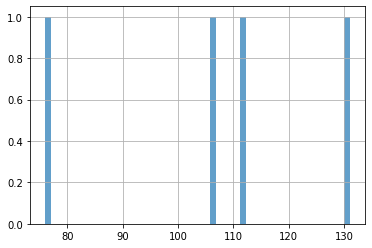

In [349]:
df_tfidf[df_tfidf.period.eq('2021-03')]['length'].hist(bins=50, alpha=0.7)

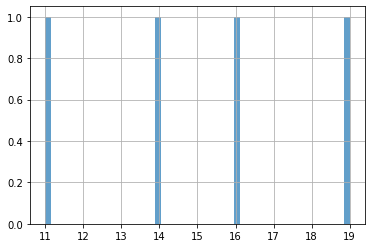

In [350]:
df_tfidf[df_tfidf.period.eq('2021-03')]['word_count'].hist(bins=50, alpha=0.7)